In [ ]:
#importing necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt

#pre-processing the data
%run pre-processing_bitcoin.ipynb

<AxesSubplot:xlabel='Date'>

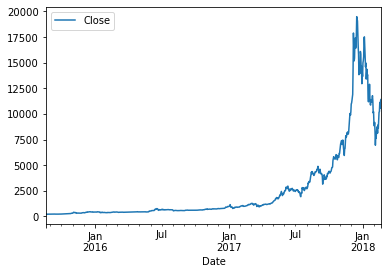

In [ ]:
#plotting the closing price of bitcoin
df1 = df[['Date','Close']]
df_ts = df1.set_index('Date')
df_ts.sort_index(inplace=True)
ts = df_ts['Close']
df_ts.plot()

Text(0.5, 0.98, 'Decomposition of time series data')

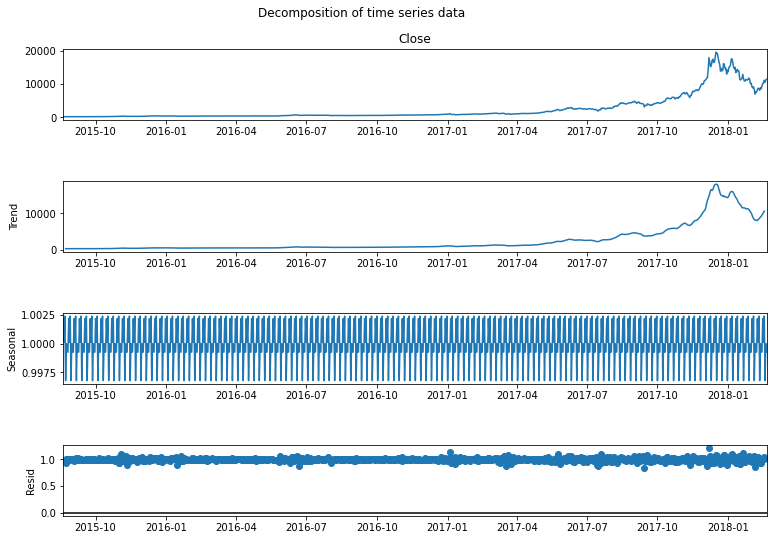

In [ ]:
#decomposition of time series data varying yearly
decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative')

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of time series data')

In [ ]:
df_ts_m = df_ts.resample('M').mean()
tsm = df_ts_m['Close']

Text(0.5, 0.98, 'Decomposition of time series data ')

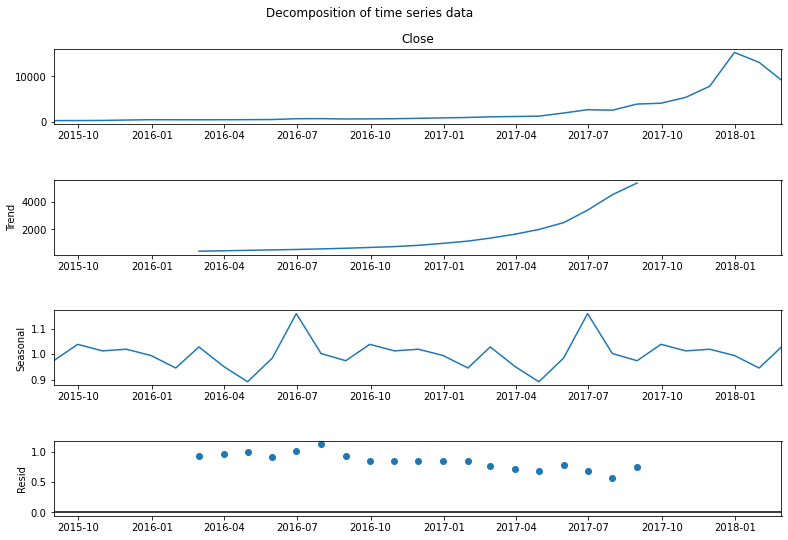

In [ ]:
#decomposition of time series data varying monthly
decomposition = sm.tsa.seasonal_decompose(tsm, model='multiplicative')
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of time series data ')

In [ ]:
#error calculation
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
#simple exponential smoothing
def exponential_smoothing(series, alpha, n_preds = 50):
    n_record = series.shape[0]
    results = np.zeros(n_record + n_preds)
    results[0] = series[0] 
    for t in range(1, n_record + 1):
        if t >= n_record:
            value = results[t - 1]
        else:
            value = series[t]

        results[t] = alpha * value + (1 - alpha) * results[t - 1]
        
    if n_preds > 1:
        results[n_record + 1:] =  alpha * results[n_record - 1] + (1 - alpha)*results[n_record]

    return results

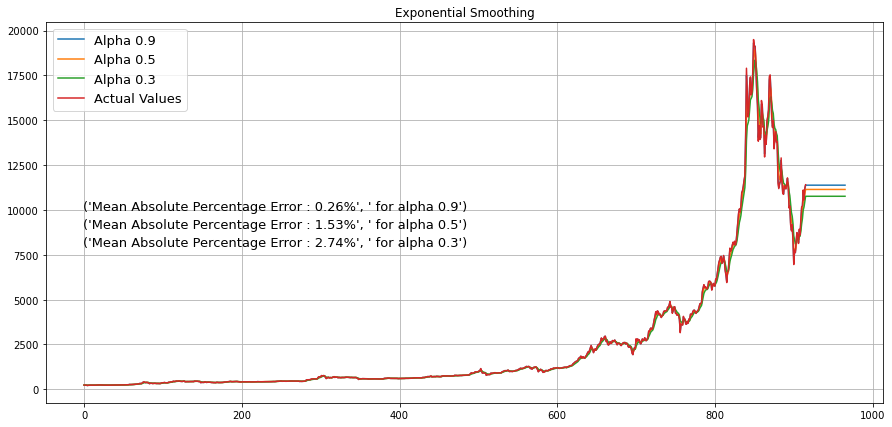

In [ ]:
#plotting the results of simple exponential smoothing
def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(15, 7))
    i = 10000
    for alpha in alphas:
        results = exponential_smoothing(series, alpha)
        plt.plot(results, label='Alpha {}'.format(alpha))
        error = mean_absolute_percentage_error(series, results[:len(series)])
        plt.text(-1.5, i, ('Mean Absolute Percentage Error : {0:.2f}%'.format(error), ' for alpha {}'.format(alpha)), fontsize=13)
        i = i - 1000
    plt.plot(series, label='Actual Values')
    plt.legend(loc='best', fontsize = 13)
    plt.axis('tight')
    plt.title('Exponential Smoothing')
    plt.grid(True)

plot_exponential_smoothing(ts.values, [0.9, 0.5, 0.3])

In [ ]:
#Holts method (double-exponential-smoothing)
def double_exponential_smoothing(series, alpha, beta, n_preds=50):
    n_record = series.shape[0]
    results = np.zeros(n_record + n_preds)
    level = series[0]
    results[0] = series[0]
    trend = series[1] - series[0]
    for t in range(1, n_record + 1):
        if t >= n_record:
            value = results[t - 1]
        else:
            value = series[t]

        previous_level = level
        level = alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - previous_level) + (1 - beta) * trend 
        results[t] = level + trend

    if n_preds > 1:
        results[n_record + 1:] = level + np.arange(2, n_preds + 1) * trend

    return results

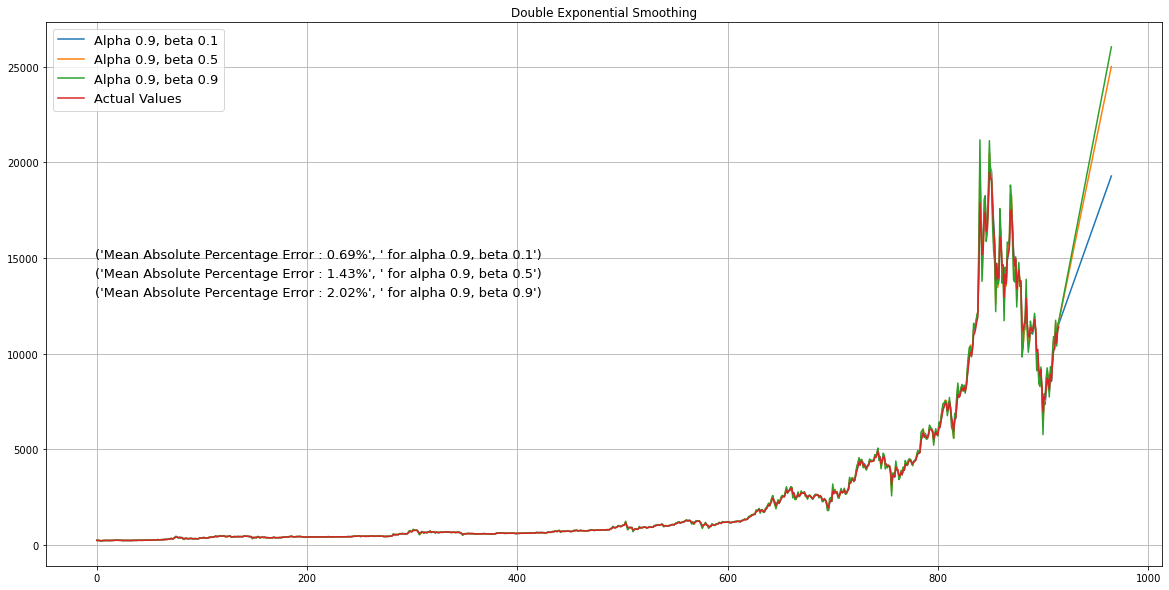

In [ ]:
#plotting the results for Holts method
def plot_double_exponential_smoothing(series, alphas, betas): 
    plt.figure(figsize=(20, 10))
    i = 15000
    for alpha, beta in zip(alphas, betas):
        results = double_exponential_smoothing(series, alpha, beta)
        plt.plot(results, label='Alpha {}, beta {}'.format(alpha, beta))
        error = mean_absolute_percentage_error(series, results[:len(series)])
        plt.text(-1.5, i, ('Mean Absolute Percentage Error : {0:.2f}%'.format(error), ' for alpha {}, beta {}'.format(alpha, beta)), fontsize=13)
        i = i - 1000
        
    plt.plot(series, label='Actual Values')
    plt.legend(loc='best', fontsize = 13)
    plt.axis('tight')
    plt.title('Double Exponential Smoothing')
    plt.grid(True)

plot_double_exponential_smoothing(ts.values, alphas=[0.9, 0.9, 0.9], betas=[0.1, 0.5, 0.9])

In [ ]:
def initial_trend(series, season_len):
    total = 0.0
    for i in range(season_len):
        total += (series[i + season_len] - series[i]) / season_len

    trend = total / season_len
    return trend

In [ ]:
def initial_seasonal(series, season_len):
        n_seasons = len(series) // season_len

        season_averages = np.zeros(n_seasons)
        for j in range(n_seasons):
            start_index = season_len * j
            end_index = start_index + season_len
            season_average = np.sum(series[start_index:end_index]) / season_len
            season_averages[j] = season_average

        seasonals = np.zeros(season_len)
        seasons = np.arange(n_seasons)
        index = seasons * season_len
        for i in range(season_len):
            seasonal = np.sum(series[index + i] - season_averages) / n_seasons
            seasonals[i] = seasonal

        return seasonals

In [ ]:
#Holt-Winters method (triple-exponential-smoothing)
def triple_exponential_smoothing(series, season_len, alpha, beta, gamma, n_preds = 50):
        # initial values
        predictions = []
        smooth = series[0]
        trend = initial_trend(series, season_len)
        seasonals = initial_seasonal(series, season_len)
        predictions.append(smooth)

        for i in range(1, len(series)):
            value = series[i]
            previous_smooth = smooth
            seasonal = seasonals[i % season_len]
            smooth = alpha * (value - seasonal) + (1 - alpha) * (previous_smooth + trend)
            trend = beta * (smooth - previous_smooth) + (1 - beta) * trend
            seasonals[i % season_len] = gamma * (value - smooth) + (1 - gamma) * seasonal
            predictions.append(smooth + trend + seasonals[i % season_len])
        
        if n_preds > 1:
            for i in range(len(predictions), len(predictions) + n_preds):
                m = i - len(predictions) + 1
                prediction = smooth + m * trend + seasonals[i % season_len]
                predictions.append(prediction)

        return predictions

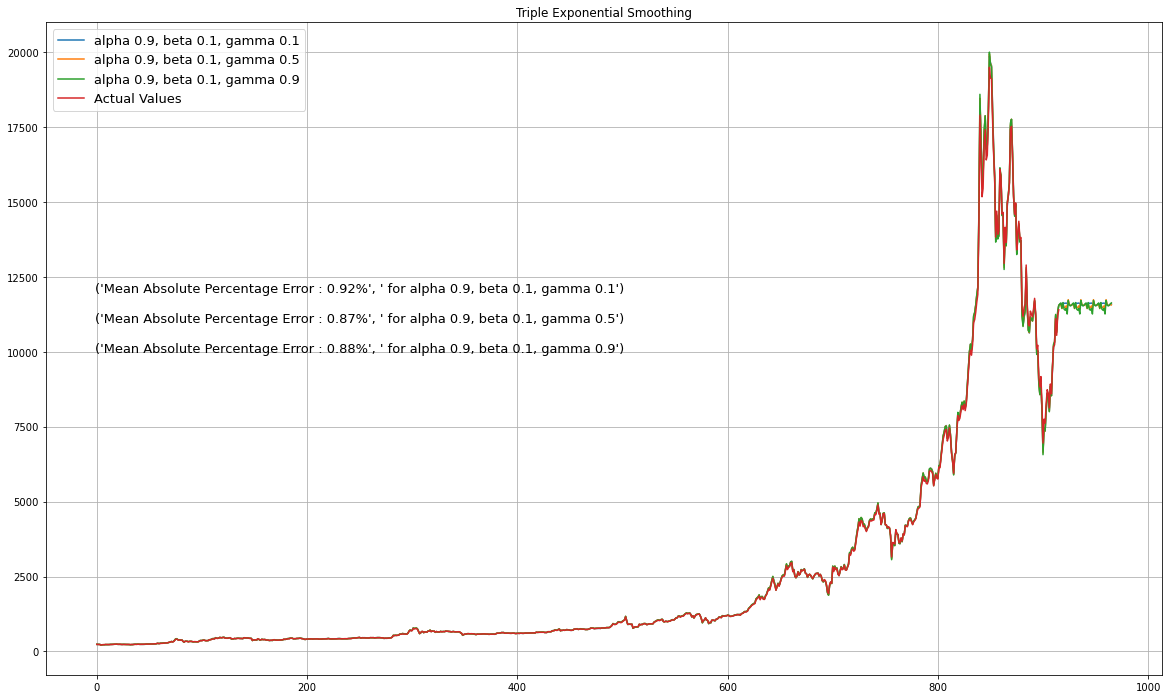

In [ ]:
#plotting the results for Holt-Winters method
def plot_triple_exponential_smoothing(series,season_len,  alphas, betas, gammas):
    plt.figure(figsize=(20, 12))
    i = 12000
    for alpha, beta, gamma in zip(alphas, betas, gammas):
        predictions = triple_exponential_smoothing(series, season_len, alpha, beta, gamma)
        plt.plot(predictions, label='alpha {}, beta {}, gamma {}'.format(alpha, beta, gamma))
        error = mean_absolute_percentage_error(series, predictions[:len(series)])
        plt.text(-1.5, i, ('Mean Absolute Percentage Error : {0:.2f}%'.format(error), ' for alpha {}, beta {}, gamma {}'.format(alpha, beta, gamma)), fontsize=13)
        i = i - 1000
    plt.plot(series, label='Actual Values')
    plt.grid(True)
    plt.axis('tight')
    plt.title('Triple Exponential Smoothing')
    plt.legend(loc='best', fontsize=13)
    plt.show()

plot_triple_exponential_smoothing(ts.values, 12, alphas=[0.9, 0.9, 0.9], betas=[0.1, 0.1, 0.1], gammas = [0.1, 0.5, 0.9])